In [1]:
import sys
sys.path.append('../code')

In [2]:
import cPickle as pickle
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
from add_model_features import add_features
from model_utilities import *

In [4]:
patch_draft_dfs = get_all_dfs('../data')

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [6]:
gbr = GradientBoostingRegressor(loss='lad')
y_test, y_old, predictions = one_patch_predictor(patch_draft_dfs, '6.86', gbr, 'regressor')

In [17]:
mse_dict = {}
gbr = GradientBoostingRegressor(loss='lad', subsample=0.8)
for key in patch_draft_dfs.iterkeys():
    y_test, y_old, predictions = one_patch_predictor(patch_draft_dfs, key, gbr, 'regressor')
    mse_dict[key] = (mean_squared_error(y_test, y_old), mean_squared_error(y_test, predictions))

In [18]:
mse_dict

{'6.78': (372.54178217821777, 347.66399469914484),
 '6.79': (469.03205882352944, 355.26093945926999),
 '6.80': (540.77529411764715, 410.84293648679045),
 '6.81': (313.62901960784313, 304.44777996028029),
 '6.82': (351.7853846153846, 287.93927151884861),
 '6.83': (573.19261682242984, 417.39607726949208),
 '6.84': (636.64851851851859, 446.47625105560542),
 '6.85': (437.96112149532706, 459.85621608835032),
 '6.86': (275.51773584905652, 201.16057241835199)}

In [19]:
np.mean([(tup[0] - tup[1])/tup[0] for tup in mse_dict.itervalues()])

0.17230914170195502

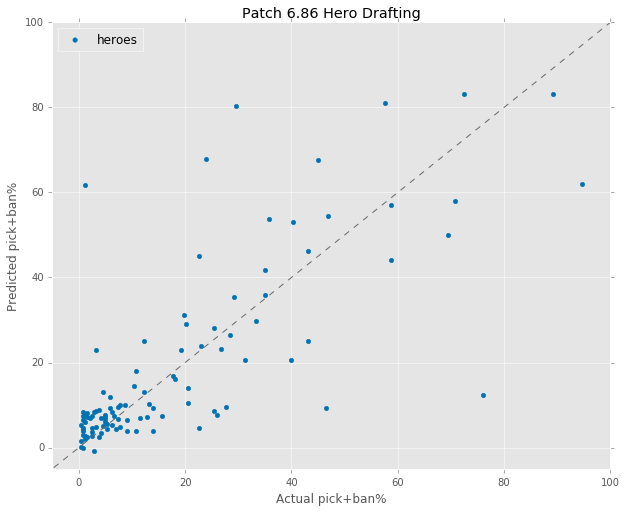

In [117]:
gbr = GradientBoostingRegressor(loss='lad')
y_test, y_old, predictions = one_patch_predictor(patch_draft_dfs, '6.86', gbr, 'regressor')
plt.figure(figsize=(10,8))
plot_scatter(y_test, predictions, '6.86', rescale=True, log=False)

In [188]:
auc_dict = {}
gbc = GradientBoostingClassifier(loss='exponential', learning_rate=0.05, n_estimators=100, subsample=0.5)
for key in patch_draft_dfs.iterkeys():
    y_test, y_old, predictions = one_patch_predictor(patch_draft_dfs, key, gbc, 'classifier', threshold=50)
    auc_dict[key] = roc_auc_score(y_test, predictions)
    
np.mean(auc_dict.values())

0.77563195932104168

In [101]:
auc_dict

{'6.78': 0.80310077519379841,
 '6.79': 0.80536398467432946,
 '6.80': 0.69444444444444442,
 '6.81': 0.80543478260869561,
 '6.82': 0.83870967741935487,
 '6.83': 0.6195876288659794,
 '6.84': 0.64898785425101213,
 '6.85': 0.80114566284779054,
 '6.86': 0.87399770904925544}

In [10]:
np.mean(auc_dict.values())

0.73184300725917706

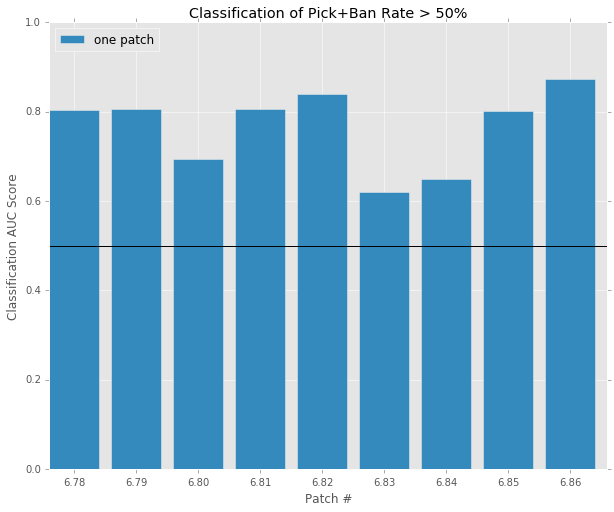

In [155]:
plt.figure(figsize=(10,8))
plt.ylim(0, 1)
plt.axhline(y=0.5, color='black', linestyle='-')
plt.bar(range(len(auc_dict)), [auc_dict[key] for key in sorted(auc_dict.keys())], label="one patch")
plt.xticks(np.arange(len(auc_dict))+0.4, sorted(auc_dict.keys()))
plt.xlabel('Patch #')
plt.ylabel('Classification AUC Score')
plt.title('Classification of Pick+Ban Rate > 50%')
plt.legend(loc='upper left')
plt.show()

In [123]:
np.mean(auc_dict.values())

0.73125727853800493

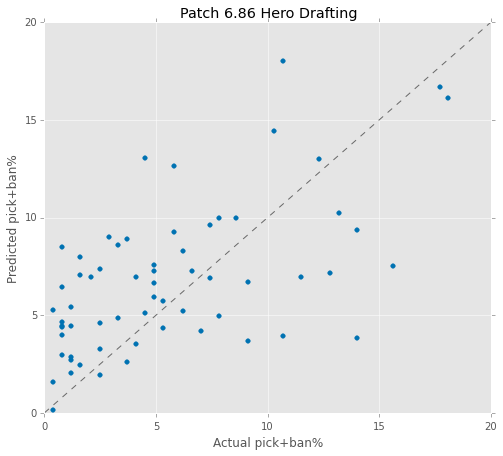

In [14]:
plt.figure(figsize=(8,7))
gbr = GradientBoostingRegressor(loss='lad')
y_test, y_old, predictions = one_patch_predictor(patch_draft_dfs, '6.86', gbr, 'regressor')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('Actual pick+ban%')
plt.ylabel('Predicted pick+ban%')
plt.title('Patch {0} Hero Drafting'.format('6.86'))
plt.plot([0, 20], [0, 20], linestyle='--', color='dimgrey')
plt.scatter(y_test, predictions*2000/np.sum(predictions), label='heroes', color='#0072B2')
plt.show()

In [171]:
pdd_copy = patch_draft_dfs.copy()
df_target = pdd_copy.pop('6.86')
df_no_target = pd.concat(pdd_copy, keys=None)
gbc = GradientBoostingClassifier(loss='exponential', learning_rate=0.05, n_estimators=100, subsample=0.5)
X_train, y_train = get_X_and_y(df_no_target, 'classifier', 50)
X_test, y_test = get_X_and_y(df_target, 'classifier', 50)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='exponential',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [172]:
fpr, tpr, thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])

In [173]:
roc_auc_score(y_test, gbc.predict_proba(X_test)[:,1])

0.88316151202749138

In [151]:
rocs = []
for i in range(1000):
    pdd_copy = patch_draft_dfs.copy()
    df_target = pdd_copy.pop('6.86')
    df_no_target = pd.concat(pdd_copy, keys=None)
    gbc = GradientBoostingClassifier(loss='exponential', learning_rate=0.05, n_estimators=100, subsample=0.5)
    X_train, y_train = get_X_and_y(df_no_target, 'classifier', 50)
    X_test, y_test = get_X_and_y(df_target, 'classifier', 50)
    gbc.fit(X_train, y_train)
    rocs.append(roc_auc_score(y_test, gbc.predict_proba(X_test)[:,1]))

(array([  14.,   50.,  145.,  214.,  245.,  191.,   96.,   39.,    5.,    1.]),
 array([ 0.83505155,  0.84295533,  0.85085911,  0.85876289,  0.86666667,
         0.87457045,  0.88247423,  0.89037801,  0.89828179,  0.90618557,
         0.91408935]),
 <a list of 10 Patch objects>)

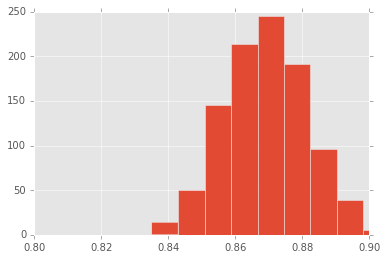

In [152]:
plt.xlim(0.8, 0.9)
plt.hist(rocs)

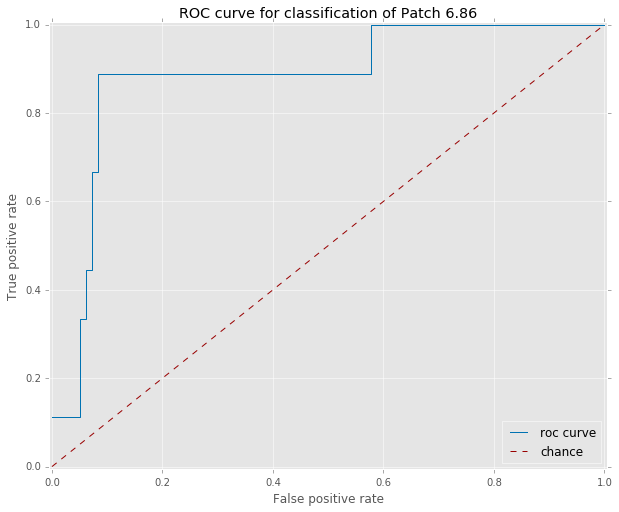

In [187]:
plt.figure(figsize=(10,8))
plt.xlim(-0.005, 1.005)
plt.ylim(-0.005, 1.005)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for classification of Patch 6.86')
plt.plot(fpr, tpr, label='roc curve', color='#0072B2')
plt.plot([0, 1], [0, 1], '--', label='chance', color='#990000')
plt.legend(loc='lower right')
plt.show()

In [160]:
len(set(gbc.predict_proba(X_test)[:,1]))

104

In [75]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

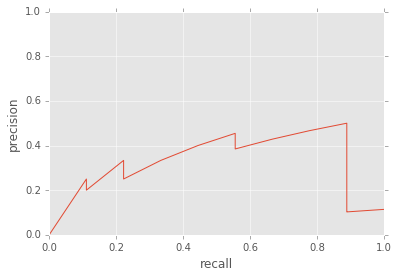

In [90]:
y_score = gbc.predict_proba(X_test)

average_precision_score(y_test, y_score[:, 1])
precision, recall, _ = precision_recall_curve(y_test, y_score[:, 1])
plt.plot(recall, precision)
plt.ylabel('precision')
plt.xlabel('recall')
plt.show()

In [87]:
average_precision_score(y_test, y_score[:, 1])

0.32478473237966909